[Previous: Exponential smoothing](08-Exponential-smoothing.ipynb)
• [Contents](Contents.ipynb)
• [Next: Dynamic regression models](10-Dynamic-regression-models.ipynb)

# 9 ARIMA models

[FPP3 Chapter 9](https://otexts.com/fpp3/arima.html)

* [9.1 Stationarity and differencing](#9.1-Stationarity-and-differencing)
* [9.2 Backshift notation](#9.2-Backshift-notation)
* [9.3 Autoregressive models](#9.3-Autoregressive-models)
* [9.4 Moving average models](#9.4-Moving-average-models)
* [9.6 Estimation and order selection](#9.6-Estimation-and-order-selection)
* [9.7 ARIMA modelling in ~R~ Python](#9.7-ARIMA-modelling-in-R-Python)
* [9.8 Forecasting](#9.8-Forecasting)
* [9.9 Seasonal ARIMA models](#9.9-Seasonal-ARIMA-models)
* [9.10 ARIMA vs ETS](#9.10-ARIMA-vs-ETS)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

[utils.py](utils.py)

## 9.1 Stationarity and differencing

[FPP3 Section 9.1](https://otexts.com/fpp3/stationarity.html)

*A stationary time series is one whose properties do not depend on the time at which the series is observed.*

In [2]:
goog = pd.read_csv('data/tsibbledata/gafa_stock.csv').query("Symbol == 'GOOG'")
goog = goog.set_index(pd.to_datetime(goog.Date, format='%Y-%m-%d'))

In [3]:
# strikes = pd.read_html('https://www.bls.gov/web/wkstp/annual-listing.htm', skiprows=1)[0]
strikes = pd.read_excel('data/external/strikes-annual-listing.xlsx', skiprows=2)
strikes = strikes.loc[:71, strikes.columns[:2]].astype(int)
strikes.columns = 'Year', 'Count'

In [4]:
housing = (
    pd.read_csv('data/external/enigma-us.gov_.census.eits_.ressales-'
                'e7513e56d76050c05caf638306055c98_1.csv')
    .query("dt_code == 'TOTAL' and cat_code == 'SOLD' and geo_desc == 'United States'")
    .rename(columns={'per_name':'date', 'val':'Count'})
    .pipe(compute, lambda x: dict(date = pd.to_datetime(x.date)))
    .set_index('date')
    [['Count']]
)

In [5]:
us_econ = pd.read_csv('data/tsibbledata/global_economy.csv')
us_econ = (
    us_econ
    .query("Code == 'USA'")
    .assign(date=pd.to_datetime(us_econ.Year, format='%Y'))
    .set_index('date')
)

In [6]:
eggs = pd.read_csv('data/external/eggs.csv')
eggs.columns = 'date', 'EggPrice'
eggs = (
    eggs
    .set_index(pd.to_datetime(eggs.date))
    .join(us_econ.resample('1MS').max().fillna(method='ffill'))
)

In [7]:
d = pd.read_csv('data/tsibbledata/aus_livestock.csv')
vic_pigs = (
    d
    .assign(date = pd.to_datetime(d.Month, format='%Y %b'))
    .query("Animal == 'Pigs' and State == 'Victoria'")
    .groupby('date Animal'.split())
    .Count.sum().reset_index()
    .set_index('date')
)

In [8]:
lynx = rdatasets.data('datasets', 'lynx')
lynx = (
    lynx
    .assign(date=pd.to_datetime(lynx.time, format='%Y'))
    .set_index('date')
)

In [9]:
d = pd.read_csv('data/tsibbledata/aus_production.csv')
aus_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .set_index('Date')
)
recent_production = aus_production.query("Date.dt.year >= 1992")

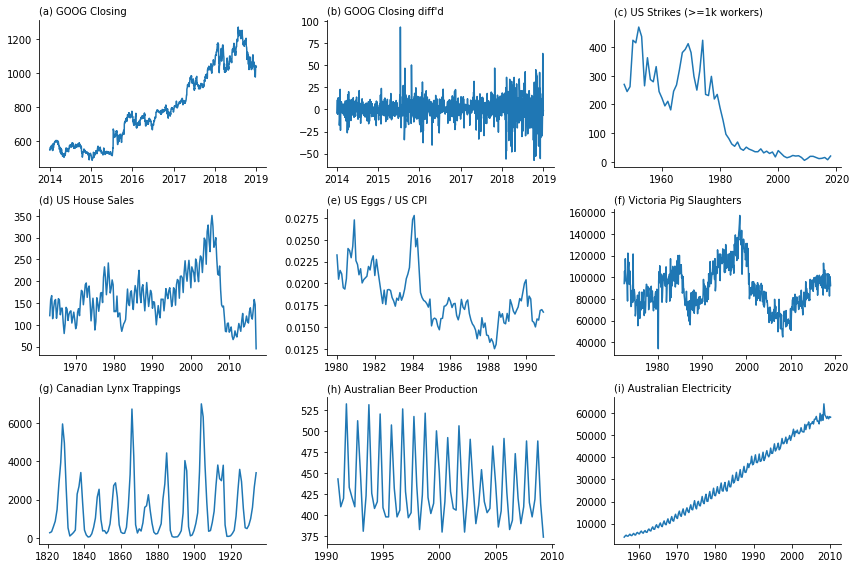

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(12,8))
axs = axs.ravel()
d = goog
axs[0].plot(d.Close)
axs[1].plot(d.Close.diff())

d = strikes
axs[2].plot(d.Year, d.Count)

d = housing
axs[3].plot(d.resample('1q').sum().Count)

d = eggs
axs[4].plot((d.EggPrice / d.CPI).loc[:'1990'])

d = vic_pigs
axs[5].plot(d.Count)

d = lynx
axs[6].plot(d.value)

d = recent_production
axs[7].plot(d.Beer)

d = aus_production
axs[8].plot(d.Electricity)

titles = [
    'GOOG Closing',
    'GOOG Closing diff\'d',
    'US Strikes (>=1k workers)',
    'US House Sales',
    'US Eggs / US CPI',
    'Victoria Pig Slaughters',
    'Canadian Lynx Trappings',
    'Australian Beer Production',
    'Australian Electricity',
]
for (ax, title, letter) in zip(axs, titles, 'abcdefghi'):
    ax.set(title=f'({letter}) {title}')
xdate(axs[-2], '%Y', '5y')
plt.tight_layout()

### Differencing

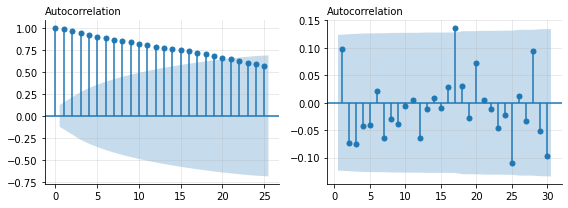

In [11]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(8,3))
d = g15 = goog['2015':'2015']
sm.graphics.tsa.plot_acf(d.Close, ax=a1)
sm.graphics.tsa.plot_acf(d.Close.diff().dropna(), lags=np.r_[1:31], ax=a2)
[ax.grid() for ax in (a1,a2)]
plt.tight_layout()

In [12]:
sm.stats.acorr_ljungbox(
    d.Close.diff().dropna(), lags=[10], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.914143,0.637223,7.744517,0.653776


### Random walk model

Drift model (5.2): $y_t = c + y_{t-1} + \varepsilon_t$.

### Second-order differencing

### Seasonal differencing

In [13]:
PBS = pd.read_csv('data/tsibbledata/PBS.csv', parse_dates=['Month'])
a10 = (
    PBS
    .query('ATC2 == "A10"')
    .groupby('Month', sort=False)
    .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
    .reset_index()
    .set_index('Month', drop=False)
)
a10

,Month,Cost
Month,,
1991-07-01,1991-07-01,3.526591
1991-08-01,1991-08-01,3.180891
1991-09-01,1991-09-01,3.252221
1991-10-01,1991-10-01,3.611003
1991-11-01,1991-11-01,3.565869
...,...,...
2008-02-01,2008-02-01,21.654285
2008-03-01,2008-03-01,18.264945
2008-04-01,2008-04-01,23.107677


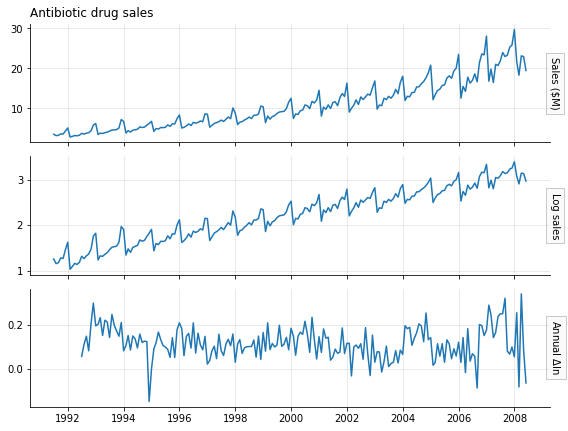

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(8,6), sharex=True)
d = a10
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
axs[2].plot(np.log(d.Cost).diff(12))
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Antibiotic drug sales')
fig.subplots_adjust(top=.95)

In [15]:
h02 = (
    PBS
    .query('ATC2 == "H02"')
    .groupby('Month', sort=False)
    .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
    .reset_index()
    .set_index('Month', drop=False)
)
h02

,Month,Cost
Month,,
1991-07-01,1991-07-01,0.429795
1991-08-01,1991-08-01,0.400906
1991-09-01,1991-09-01,0.432159
1991-10-01,1991-10-01,0.492543
1991-11-01,1991-11-01,0.502369
...,...,...
2008-02-01,2008-02-01,0.761822
2008-03-01,2008-03-01,0.649435
2008-04-01,2008-04-01,0.827887


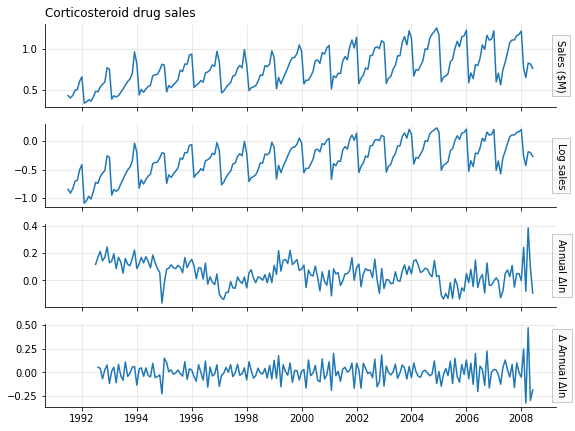

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True)
d = h02
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
axs[2].plot(np.log(d.Cost).diff(12))
axs[3].plot(np.log(d.Cost).diff(12).diff())
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$', '$\Delta$ Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Corticosteroid drug sales')
fig.subplots_adjust(top=.95)

### Unit root tests

In [17]:
sm.tsa.stattools.kpss(g15.Close, nlags='auto')

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(2.009369275593299,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [18]:
sm.tsa.stattools.kpss(g15.Close.diff().diff().dropna(), nlags='auto')

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.30931181562645355,
 0.1,
 104,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [19]:
ndiffs, nsdiffs = pmd.arima.ndiffs, pmd.arima.nsdiffs

In [20]:
ndiffs(g15.Close), nsdiffs(g15.Close, 30)

(1, 0)

In [21]:
ndiffs(a10.Cost), ndiffs(h02.Cost), nsdiffs(a10.Cost, 12), nsdiffs(h02.Cost, 12)

(1, 1, 1, 1)

## 9.2 Backshift notation

[FPP3 Section 9.2](https://otexts.com/fpp3/backshift.html)

## 9.3 Autoregressive models

[PFF3 Section 9.3](https://otexts.com/fpp3/AR.html)

## 9.4 Moving average models

[FPP3 Section 9.4](https://otexts.com/fpp3/MA.html)

### US consumption expenditure

In [22]:
us_change = pd.read_csv('data/fpp3/us_change.csv')
us_change = (
    us_change
    .assign(date=pd.to_datetime(us_change.Quarter.str.replace(' ', '')))
    .set_index('date')
    .pipe(set_freq)
)

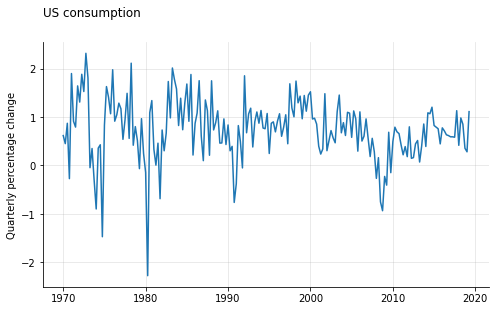

In [23]:
fig, ax = plt.subplots()
ax.plot(us_change.Consumption)
ax.set(ylabel='Quarterly percentage change')
suptitle('US consumption')
ax.grid()

In [24]:
fit = sm.tsa.SARIMAX(us_change.Consumption, order=(1, 0, 3), trend='c').fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -169.883
Date:                Sat, 21 Sep 2024   AIC                            351.766
Time:                        21:04:33   BIC                            371.495
Sample:                    01-01-1970   HQIC                           359.752
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3159      0.090      3.513      0.000       0.140       0.492
ar.L1          0.5732      0.124      4.639      0.000       0.331       0.815
ma.L1         -0.3619      0.128     -2.824      0.005      -0.613      -0.111
ma.L2          0.0925      0.061      1.528      0.127      -0.026       0.211
ma.L3          0.1933      0.076      2.547      0.011       0.045       0.342
sigma2         0.3250      0.023     14.190      0.000       0.280       0.370
===================================================================================
Ljung-Box (Q):                       40.83   Jarque-Bera (JB):                74.75
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

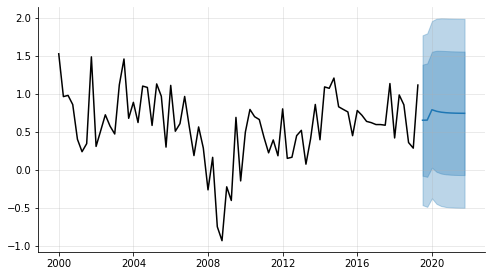

In [25]:
fig, ax = plt.subplots()
ax.plot(us_change['2000':].Consumption, 'k')

fc = fit.get_forecast(10)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

### Understanding ARIMA models

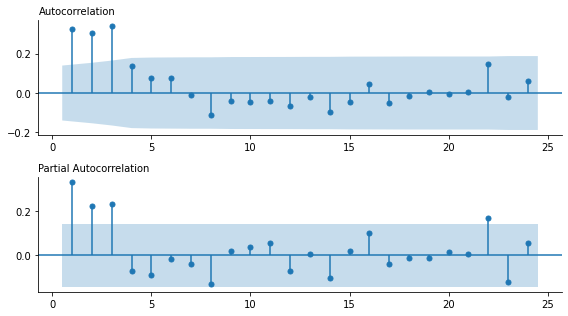

In [26]:
fig, axs = plt.subplots(2)
lags = np.r_[1:25]
sm.graphics.tsa.plot_acf(us_change.Consumption, lags=lags, ax=axs[0]);
sm.graphics.tsa.plot_pacf(us_change.Consumption, lags=lags, ax=axs[1]);
plt.tight_layout()

In [27]:
fit = sm.tsa.SARIMAX(us_change.Consumption, order=(3, 0, 0), trend='c').fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -170.300
Date:                Sat, 21 Sep 2024   AIC                            350.600
Time:                        21:04:33   BIC                            367.041
Sample:                    01-01-1970   HQIC                           357.255
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3045      0.060      5.090      0.000       0.187       0.422
ar.L1          0.2027      0.056      3.648      0.000       0.094       0.312
ar.L2          0.1605      0.055      2.907      0.004       0.052       0.269
ar.L3          0.2252      0.064      3.529      0.000       0.100       0.350
sigma2         0.3264      0.022     14.593      0.000       0.283       0.370
===================================================================================
Ljung-Box (Q):                       40.31   Jarque-Bera (JB):                74.38
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 9.6 Estimation and order selection

[FPP3 Section 9.6](https://otexts.com/fpp3/arima-estimation.html)

### Information Criteria

## 9.7 ARIMA modelling in ~R~ Python

[FPP3 Section 9.7](https://otexts.com/fpp3/arima-r.html)

**TODO:** skipped for now.

## 9.8 Forecasting

[FPP3 Section 9.8](https://otexts.com/fpp3/arima-forecasting.html)

### Point forecasts

### Prediction intervals

## 9.9 Seasonal ARIMA models

[FPP3 Section 9.9](https://otexts.com/fpp3/seasonal-arima.html)

### ACF/PACF

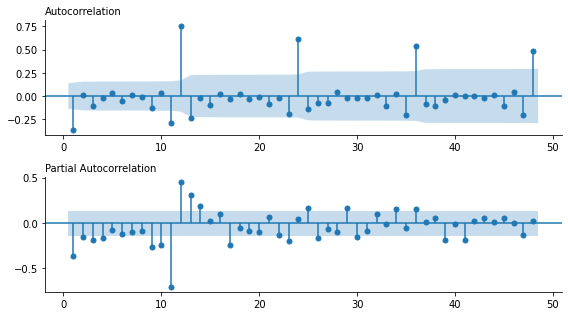

In [28]:
fig, axs = plt.subplots(2)
lags = np.r_[1:4*12+1]
sm.graphics.tsa.plot_acf(a10.Cost.diff().dropna(), lags=lags, ax=axs[0]);
sm.graphics.tsa.plot_pacf(a10.Cost.diff().dropna(), lags=lags, ax=axs[1]);
plt.tight_layout()

### Example: European quarterly retail trade

**TODO:** where is the dataset?

### Example: Corticosteroid drug sales in Australia

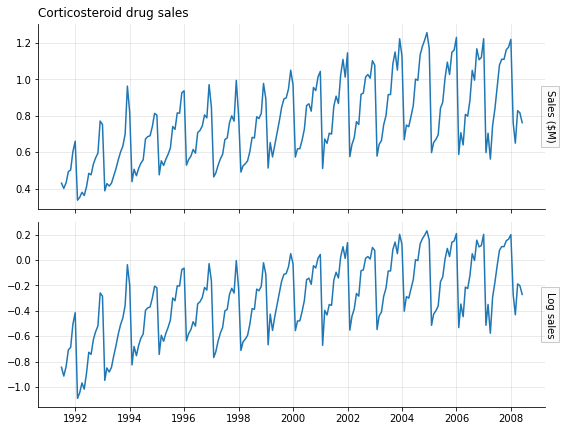

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
d = h02
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$', '$\Delta$ Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Corticosteroid drug sales')
fig.subplots_adjust(top=.95)

Check seasonal difference:

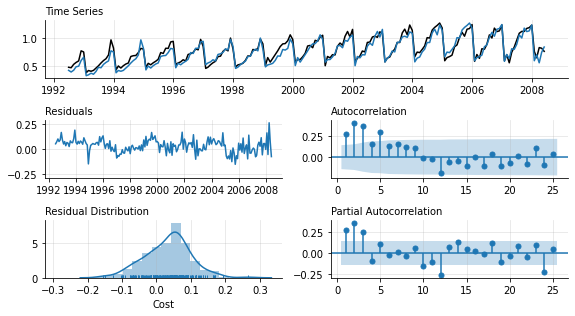

In [30]:
plot_tsresiduals(h02.Cost, h02.Cost.shift(12));

Ordinary:
* Probably P ~ 3
* No need for D > 0
* MA unclear

Seasonal:
* Need 1 difference

First brute force it manually:

In [31]:
%%time

results = []
P, D, d, m = 3, 0, 1, 12
for (Q, p, q) in tqdm(list(itertools.product(range(2), range(3), range(3)))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fit = sm.tsa.SARIMAX(np.log(h02.Cost), order=(P,D,Q), seasonal_order=(p,d,q,m)).fit()
        result = dict(P=P, Q=Q, D=D, p=p, d=d, q=q, m=m,
                      label=f'SARIMA({P},{D},{Q})({p}{d}{q}){m}',
                      AIC=fit.aic, fit=fit)
    results.append(result)
results = pd.DataFrame(results)

100%|██████████| 18/18 [01:15<00:00,  4.18s/it]

CPU times: user 8min 24s, sys: 10min 42s, total: 19min 7s
Wall time: 1min 15s


In [32]:
results.sort_values('AIC')['label AIC'.split()]

,label,AIC
16,"SARIMA(3,0,1)(211)12",-486.413474
11,"SARIMA(3,0,1)(012)12",-486.082662
2,"SARIMA(3,0,0)(012)12",-484.987959
13,"SARIMA(3,0,1)(111)12",-484.860259
14,"SARIMA(3,0,1)(112)12",-484.495435
7,"SARIMA(3,0,0)(211)12",-484.450641
4,"SARIMA(3,0,0)(111)12",-484.299477
1,"SARIMA(3,0,0)(011)12",-484.189612
8,"SARIMA(3,0,0)(212)12",-484.137918
10,"SARIMA(3,0,1)(011)12",-484.116986


In [33]:
results[11:12]

,P,Q,D,p,d,q,m,label,AIC,fit
11,3,1,0,0,1,2,12,"SARIMA(3,0,1)(012)12",-486.082662,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


Then try with [pmdarima](http://alkaline-ml.com/pmdarima/):

In [34]:
fit_auto = pmd.auto_arima(
    np.log(h02.Cost),
    seasonal=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-102.592, BIC=-82.713, Time=0.200 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-60.444, BIC=-53.818, Time=0.015 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-61.490, BIC=-51.551, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-61.943, BIC=-52.003, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-62.407, BIC=-59.093, Time=0.009 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-96.554, BIC=-79.988, Time=0.155 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-97.186, BIC=-80.620, Time=0.167 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA

In [35]:
fit_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(3, 1, 2)   Log Likelihood                  59.669
Date:                Sat, 21 Sep 2024   AIC                           -105.339
Time:                        21:05:51   BIC                            -82.146
Sample:                             0   HQIC                           -95.956
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.001      3.550      0.000       0.001       0.004
ar.L1         -0.2778      0.132     -2.098      0.036      -0.537      -0.018
ar.L2          0.5743      0.102      5.613      0.000       0.374       0.775
ar.L3         -0.1440      0.111     -1.300      0.194      -0.361       0.073
ma.L1         -0.0139      8.340     -0.002      0.999     -16.360      16.332
ma.L2         -0.9860      8.244     -0.120      0.905     -17.144      15.172
sigma2         0.0325      0.271      0.120      0.905      -0.499       0.564
===================================================================================
Ljung-Box (Q):                      466.81   Jarque-Bera (JB):               123.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -1.41
Prob(H) (two-sided):                  0.88   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

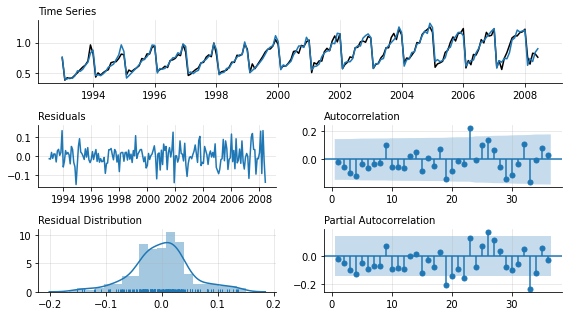

In [36]:
plot_tsresiduals(h02.Cost['1993':], np.exp(results.fit[11].fittedvalues['1993':]),
                 acf_lags=np.r_[1:37]);

Plotting takes a lil bit of care because `pmd.auto_arima()` threw away the DateTimeIndex.

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


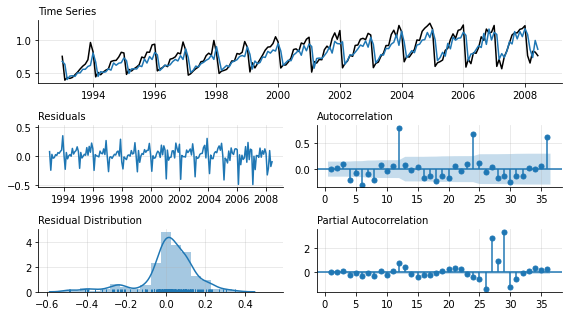

In [37]:
fit = fit_auto.arima_res_
mask = h02.index >= '1993'
ypred = pd.Series(fit.fittedvalues[mask], index=h02.index[mask])
plot_tsresiduals(h02.Cost['1993':], np.exp(ypred),
                 acf_lags=np.r_[1:37]);

### Test set evaluation

In [38]:
split = '2006-06-02'
tend = '2008-06-02'
dtrain, dtest = a10[:split], a10[split:tend]
m = sm.tsa.SARIMAX(np.log1p(dtrain.Cost), order=(3, 0, 1), seasonal_order=(0,1,2,12))
fit = m.fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


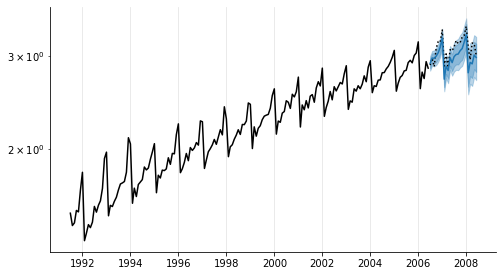

In [39]:
fig, ax = plt.subplots()
ax.plot(np.log1p(dtrain.Cost), 'k')
ax.plot(np.log1p(dtest.Cost), 'k:')
ax.semilogy()

fc = fit.get_forecast(2*12)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

**TODO:** test other model variants

In [40]:
m = sm.tsa.SARIMAX(np.log1p(h02.Cost), order=(3, 0, 1), seasonal_order=(0,1,2,12))
fit = m.fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


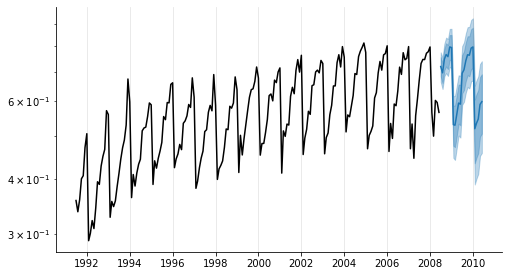

In [41]:
fig, ax = plt.subplots()
ax.plot(np.log1p(h02.Cost), 'k')
ax.semilogy()

fc = fit.get_forecast(2*12)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

## 9.10 ARIMA vs ETS

[FPP3 Section 9.10](https://otexts.com/fpp3/arima-ets.html)

### Example: Comparing ARIMA() and ETS() on non-seasonal data

In [42]:
aus_econ = pd.read_csv('data/tsibbledata/global_economy.csv')
aus_econ = (
    aus_econ
    .assign(date=pd.to_datetime(aus_econ.Year, format='%Y'),
            Population=aus_econ.Population/1e6)
    .query("Code == 'AUS'")
    .set_index('date')
    .pipe(set_freq)
)
aus_econ['idx'] = np.arange(len(aus_econ))

In [43]:
pop_train_cv = pd.concat([aus_econ.iloc[:n]['idx Population'.split()].assign(id=n)
                          for n in range(10, len(aus_econ)-10)])

In [44]:
pop_train_cv.id.nunique()

38

In [45]:
%%time
## ETS
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Y, y = np.transpose([
        (
            aus_econ.Population.iloc[d.idx.max()+1],
            sm.tsa.statespace.ExponentialSmoothing(set_freq(d).Population, trend=True)
                .fit().forecast(1).values[0]
        )
        for (i, d) in tqdm(pop_train_cv.groupby('id'))
    ])
ets_metrics = RMSE(Y, y), MAE(Y, y), MAPE(Y, y)
ets_metrics

100%|██████████| 38/38 [00:01<00:00, 23.71it/s]

CPU times: user 1.6 s, sys: 3.41 ms, total: 1.61 s
Wall time: 1.61 s


(0.10577834082981048, 0.07705966855094777, 0.5117408397052859)

In [46]:
%%time
## ARIMA
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Y, y = np.transpose([
        (
            aus_econ.Population.iloc[d.idx.max()+1],
            sm.tsa.SARIMAX(set_freq(d).Population, order=(3,1,1), trend='ct')
                .fit().forecast(1).values[0]
        )
        for (i, d) in tqdm(pop_train_cv.groupby('id'))
    ])
RMSE(Y, y), MAE(Y, y), MAPE(Y, y)
arima_metrics = RMSE(Y, y), MAE(Y, y), MAPE(Y, y)
arima_metrics

100%|██████████| 38/38 [00:03<00:00, 12.28it/s]

CPU times: user 5.16 s, sys: 4.13 s, total: 9.29 s
Wall time: 3.1 s


(0.07316590977954023, 0.04915140745819797, 0.3229606263038597)

In [47]:
efit = sm.tsa.statespace.ExponentialSmoothing(aus_econ.Population, trend=True).fit()

In [48]:
afit =  sm.tsa.SARIMAX(aus_econ.Population, order=(3,1,1), trend='ct').fit()

In [49]:
efit.aic, afit.aic

(-147.89550026719144, -148.1338357007595)

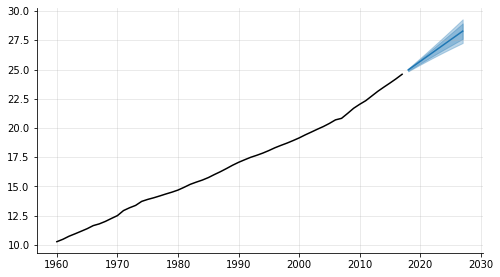

In [50]:
fig, ax = plt.subplots()
ax.plot(aus_econ.Population, 'k')

fc = efit.get_forecast(10)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

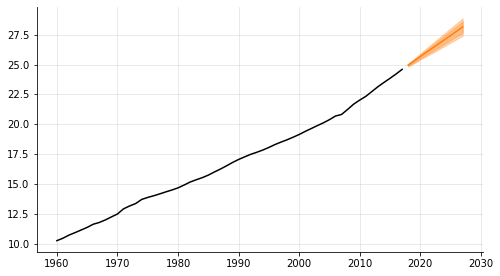

In [51]:
fig, ax = plt.subplots()
ax.plot(aus_econ.Population, 'k')

fc = afit.get_forecast(10)
ax.plot(fc.predicted_mean, color='C1')
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)

ax.grid()

### Example: Comparing ARIMA and ETS on seasonal data

In [52]:
cement = set_freq(aus_production['1988':])

In [53]:
split = '2007'
dtrain, dtest = cement[:split], cement[split:]

In [54]:
efit = sm.tsa.statespace.ExponentialSmoothing(dtrain.Cement, trend=True, seasonal=4).fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


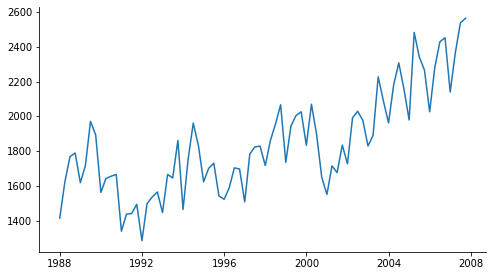

In [55]:
plt.plot(dtrain.Cement);

In [56]:
afit =  sm.tsa.SARIMAX(
    dtrain.Cement, order=(1,0,1), seasonal_order=(2,1,1,4), trend='ct').fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [57]:
efit.aic, afit.aic

(989.792857379158, 934.7676825484693)

**TODO:** more diagnostics

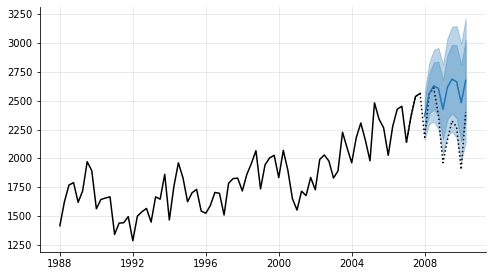

In [58]:
fig, ax = plt.subplots()
ax.plot(dtrain.Cement, 'k')
ax.plot(dtest.Cement, 'k:')

fc = efit.get_forecast(10)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

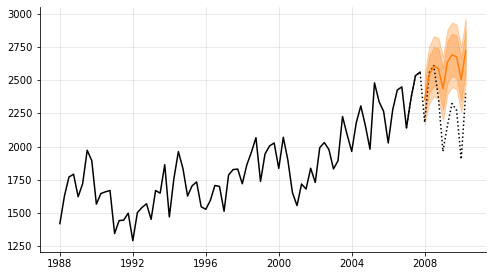

In [59]:
fig, ax = plt.subplots()
ax.plot(dtrain.Cement, 'k')
ax.plot(dtest.Cement, 'k:')

fc = afit.get_forecast(10)
ax.plot(fc.predicted_mean, color='C1')
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)

ax.grid()

<hr/>

[Previous: Exponential smoothing](08-Exponential-smoothing.ipynb)
• [Contents](Contents.ipynb)
• [Next: Dynamic regression models](10-Dynamic-regression-models.ipynb)